In [49]:
import torch
import json
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [50]:
# LOAD FINE-TUNED MODEL FROM DISK

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = torch.load('./torch-cache/test2.ckpt', map_location=torch.device('cpu'))
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

with open('./torch-cache/authors.json') as file:
    authors = json.load(file)
    print(f"Authors list: {authors}")

Total number of parameters: 109489161
Authors list: ['shakespeare', 'jonson', 'fletcher', 'ford', 'rowley', 'middleton', 'massinger', 'dekker', 'webster']


C:\Users\kauhe\AppData\Local\Temp\ipykernel_6100\1684595006.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./torch-cache/test2.ckpt', map_location=t

In [51]:
# PORT OF PREPROCESSING SCRIPT USED ON CORPUS

import re
from typing import List

def process_line(line: str) -> str:
    result = line

    # Remove stuff between brackets
    bracket_processed = False
    if '[' in line and ']' in line:
        fst_bracket_idx = line.index('[')
        snd_bracket_idx = line.index(']')
        if fst_bracket_idx < snd_bracket_idx:
            result = result[:fst_bracket_idx] + result[snd_bracket_idx + 1:]
            bracket_processed = True
    if not bracket_processed and '[' in line:
        fst_bracket_idx = line.index('[')
        result = result[:fst_bracket_idx]
        bracket_processed = True
    if not bracket_processed and ']' in line:
        snd_bracket_idx = line.index(']')
        result = result[snd_bracket_idx + 1:]
        bracket_processed = True

    # Remove symbols and ALL CAPS words, and normalize punctuation
    result = re.sub(r"[’‘]", "'", result)
    result = re.sub(r"[_,:;\[\]\{\}\(\)—“”&<>$/\\=+\`^]", '', result)
    result = re.sub(r"[0-9]", '', result)
    result = result.replace('-', ' ')
    result = re.sub(r"[\?\!]", '.', result)

    words = result.split(' ')
    words = [word for word in words if not (word.isupper() and len(word) > 1)]
    result = ' '.join(words)

    return result

def process_text(text: str) -> List[str]:
    # Remove excess white space and process each line
    lines = text.split('\n')
    lines = [line.strip() for line in lines]
    lines = [process_line(line) for line in lines]
    lines = [line for line in lines if line]
    result = ' '.join(lines)

    # Clean up sentences
    sentences = result.split('.')
    sentences = [sentence.strip().lower() for sentence in sentences]
    sentences = [sentence.split(' ') for sentence in sentences]
    sentences = [[token for token in tokens if token] for tokens in sentences]
    sentences = [
        [word for word in tokens if not (len(word) == 1 and word in [
            'b', 'c', 'f', 'g', 'h', 'j', 'k',
            'p', 'q', 'r', 'v', 'w', 'x', 'y', 'z'
        ])]
        for tokens in sentences
    ]
    sentences = [' '.join(tokens) for tokens in sentences if len(tokens) > 2]

    return sentences

In [ ]:
# FORMAT INFERENCE INPUT (RAW COPY PASTE) INTO BERT INPUT and MASK

# witch of edmonton -> rowley
sentence = """Win, I have heard the news; all now is safe;
The worst is past: thy lip, wench [_Kisses her_]: I must bid
Farewell, for fashion's sake; but I will visit thee
Suddenly, girl. This was cleanly carried;
Ha! was't not, Win?

_Win._              Then were my happiness,
That I in heart repent I did not bring him
The dower of a virginity. Sir, forgive me;
I have been much to blame: had not my lewdness[413]
Given way to your immoderate waste of virtue,
You had not with such eagerness pursued
The error of your goodness."""

# witch of edmonton -> dekker
sentence = """FRANK _searches first one pocket, then the other, finds
the knife, and then lies down.--The ~Dog~ runs off.--The spirit
of_ SUSAN _comes to the bed's side_; FRANK
_stares at it, and then turns to the other side, but the spirit
is there too. Meanwhile enter_ WINNIFRED _as a page,
and stands sadly at the bed's foot_.--FRANK _affrighted
sits up. The spirit vanishes._
_Frank._ What art thou?
_Win._                  A lost creature.
_Frank._                                 So am I too.--Win?
Ah, my she-page!
_Win._           For your sake I put on
A shape that's false; yet do I wear a heart
True to you as your own.
"""


sentences = process_text(sentence)
tokens = [t for sublist in [tokenizer.tokenize(s) for s in sentences] for t in sublist]

MAX_SEQUENCE_LEN = 128
current_input = ["CLS"]
current_input.extend(tokens[0:min(MAX_SEQUENCE_LEN - 2, len(tokens))])
current_input.append("[SEP]")
mask = [1 for _ in range(len(current_input))]
while len(current_input) != MAX_SEQUENCE_LEN:
    current_input.append("[PAD]")
    mask.append(0)
inputs = tokenizer.convert_tokens_to_ids(current_input)

In [63]:
# RUN INFERENCE

x_inputs = torch.tensor(inputs).unsqueeze(0)
x_masks = torch.tensor(mask).unsqueeze(0)
print(x_inputs)

model.eval()
outputs = model(x_inputs, token_type_ids=None, attention_mask=x_masks, output_attentions=True) 
logits = outputs.logits
print(logits)

tensor([[  100, 17193,  2034,  2028,  4979,  2059,  1996,  2060,  4858,  1996,
          5442,  1998,  2059,  3658,  2091,  1996,  1066,  3899,  1066,  3216,
          2125,  1996,  4382,  1997,  3310,  2000,  1996,  2793,  1005,  1055,
          2217, 14020,  2012,  2009,  1998,  2059,  4332,  2000,  1996,  2060,
          2217,  2021,  1996,  4382,  2003,  2045,  2205,  5564,  4607,  2004,
          1037,  3931,  1998,  4832, 13718,  2012,  1996,  2793,  1005,  1055,
          3329, 21358, 19699, 18743,  2098,  7719,  2039,  1996,  4382, 25887,
          2229,  2054,  2396, 15223,  1037,  2439,  6492,  2061,  2572,  1045,
          2205,  6289,  2026,  2016,  3931,  2005,  2115,  8739,  1045,  2404,
          2006,  1037,  4338,  2008,  1005,  1055,  6270,  2664,  2079,  1045,
          4929,  1037,  2540,  2995,  2000,  2017,  2004,  2115,  2219,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

C:\Users\kauhe\AppData\Local\Temp\ipykernel_6100\2339357619.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = np.array(F.softmax(logits).detach().numpy()[0])


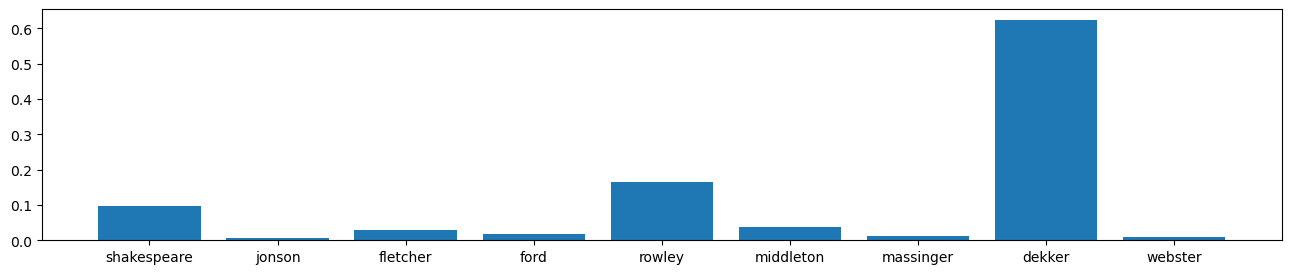

In [64]:
# PLOT CLASSIFICATION LOGITS

import torch.nn.functional as F
import matplotlib.pyplot as plt

x = np.array(authors)
y = np.array(F.softmax(logits).detach().numpy()[0])

plt.figure(figsize=(16, 3))
plt.bar(x,y)
plt.show()